# Geodata Attack - Using GPS

In [1]:
import skmob
from sklearn.cluster import DBSCAN
from skmob.utils import constants
from skmob.utils import utils

from geopy.distance import distance
import pandas as pd
import numpy as np
import csv
import folium

## Preprocessing GPS Data

### Load data from file

In [2]:
gps = '../../privamov/privamov-gps'
gsm = '../../privamov/privamov-gsm'
preprocessed_file = '../../privamov/pre_processed.csv'
wifi = '../../privamov/privamov-wifi'

Loading only a subset of data from `privamov-gps.csv` , by using `MAX_LINES` and `SKIP_LINES`

In [3]:
def formatGPS(file, MAX_LINES = 10**7, SKIP_LINES = 50):
    ids = []
    horodate = []
    lat = []
    long = []
    i = 0
    t = 0
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t', quotechar="'")
        for row in csv_reader:
            if t == SKIP_LINES:
                ids.append(row[0])
                horodate.append(row[1])
                lat.append(row[3])
                long.append(row[2])
                if i > MAX_LINES : 
                    break
                t=0
            else :
                t+=1
            i+=1
        d = { 'ID': ids, 'Horodate':horodate, 'Latitude':lat, 'Longitude':long}  
        df = pd.DataFrame(data=d)
    return df

### Build DataFrame & Quick Visualization

In [4]:
df_gps = formatGPS(preprocessed_file, SKIP_LINES=0)
df_gps.head()

ID                 Horodate          Latitude         Longitude
0  1  2014-10-04 08:40:42.085  43.4094833333333  3.68737333333333
1  1  2014-10-04 08:41:32.161  43.4094416666667           3.68725
2  1  2014-10-04 08:42:22.161  43.4092883333333  3.68749333333333
3  1  2014-10-04 08:43:13.161  43.4094033333333  3.68728166666667
4  1  2014-10-04 08:44:05.161  43.4093516666667  3.68739166666667

Aggregating number of points by IDs

In [5]:
def get_unique_id(df):
    ids = df['ID']
    unique_id = set()
    for ident in ids:
        unique_id.add(ident)
    return unique_id  

In [6]:
unique_id = sorted(list(get_unique_id(df_gps)))
print(unique_id)

['1', '103', '105', '107', '109', '11', '110', '112', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '39', '4', '40', '41', '42', '43', '44', '46', '48', '49', '50', '51', '52', '53', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '75', '77', '78', '79', '8', '80', '81', '82', '83', '85', '86', '87', '89', '9', '93', '94', '95', '99']


In [7]:
agg = df_gps.groupby('ID').size().reset_index(name='counts')
agg.sort_values(by='counts',ascending=False).head()

ID  counts
61  69   77729
43  50   64019
34   4   60402
37  42   42211
51  59   41863

## Sampling the Data

```
def sample_by_id(file, ident='1'):
    with open(file, 'r') as i, open('subsamples/privamov_gps_id_{}.csv'.format(ident), 'w', newline='') as o:
        r = csv.reader(i, delimiter='\t')
        w = csv.writer(o, delimiter='\t')
        for row in r:
            if row[0] == ident:
                w.writerow(row)
```

```
sample_by_id(gps,'2')
```

### Build SKMOB Object & Visualize trajectories

In [8]:
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID')
tdf.head()

uid                datetime        lat       lng
0   1 2014-10-04 08:40:42.085  43.409483  3.687373
1   1 2014-10-04 08:41:32.161  43.409442  3.687250
2   1 2014-10-04 08:42:22.161  43.409288  3.687493
3   1 2014-10-04 08:43:13.161  43.409403  3.687282
4   1 2014-10-04 08:44:05.161  43.409352  3.687392

In [9]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 85
number of records:	 1380589


## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [10]:
from skmob.preprocessing import filtering

In [11]:
ftdf = filtering.filter(tdf, max_speed_kmh=400.)

Very few points have been filtered.

In [12]:
print('Points of the raw trajectory: %s'%len(tdf))
print('Points of the filtered trajectory: %s'%len(ftdf))

Points of the raw trajectory: 1380589
Points of the filtered trajectory: 1378895


## Compression

Reduce the number of points of the trajectory, preserving the structure.

Merge together all points that are closer than `spatial_radius_km`=0.2 kilometers from each other.

In [13]:
from skmob.preprocessing import compression

In [14]:
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
ctdf[:4]

uid                datetime        lat       lng
0   1 2014-10-04 08:40:42.085  43.409325  3.687527
1   1 2014-10-08 07:16:46.104  45.775830  4.870896
2   1 2014-10-08 07:20:07.105  45.776497  4.873762
3   1 2014-10-08 07:23:27.105  45.778868  4.874568

The compressed trajectory has only a small fraction of the points of the filtered trajectory (less than 10%)

In [15]:
print('Points of the filtered trajectory: %s'%len(ftdf))
print('Points of the compressed trajectory: %s'%len(ctdf))

Points of the filtered trajectory: 1378895
Points of the compressed trajectory: 72685


## Stop detection

Identify locations where the user spent at least minutes_for_a_stop minutes within a `distance spatial_radius_km` $\times$ `stop_radius_factor`, from a given point.

A new column `leaving_datetime` is added, indicating the time when the user departs from the stop.

In [16]:
from skmob.preprocessing import detection

In [17]:
stdf = detection.stops(ctdf, stop_radius_factor=1, \
            minutes_for_a_stop=30, spatial_radius_km=0.5, 
                       leaving_time=True)
stdf[:4]

uid                datetime        lat       lng            leaving_datetime
0   1 2014-10-04 08:40:42.085  43.409325  3.687527  2014-10-08 07:16:46.104000
1   1 2014-10-08 07:23:27.105  45.779414  4.874958  2014-10-08 08:04:42.104000
2   1 2014-10-08 08:04:42.104  45.787001  4.879866  2014-10-08 16:09:43.105000
3   1 2014-10-08 16:30:33.107  45.770915  4.869998  2014-10-09 07:16:39.993000

**Visualise the compressed trajectory and the stops**

Click on the stop markers to see a pop up with:

* User ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [18]:
map_f = ctdf.plot_trajectory(max_points=1, hex_color=-1, start_end_markers=False)
stdf.plot_stops(map_f=map_f, hex_color=-1)

## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column cluster is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to.

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [19]:
from skmob.preprocessing import clustering

In [20]:
cstdf = clustering.cluster(stdf, cluster_radius_km=0.2, min_samples=1)
cstdf

uid                datetime        lat       lng        leaving_datetime  \
0      1 2014-10-04 08:40:42.085  43.409325  3.687527 2014-10-08 07:16:46.104   
1      1 2014-10-08 07:23:27.105  45.779414  4.874958 2014-10-08 08:04:42.104   
2      1 2014-10-08 08:04:42.104  45.787001  4.879866 2014-10-08 16:09:43.105   
3      1 2014-10-08 16:30:33.107  45.770915  4.869998 2014-10-09 07:16:39.993   
4      1 2014-10-09 07:45:18.984  45.787913  4.879948 2014-10-10 10:48:25.010   
...   ..                     ...        ...       ...                     ...   
6289  94 2014-12-10 11:40:17.914  45.764424  4.982879 2014-12-11 12:20:17.914   
6290  94 2014-12-11 12:20:17.914  45.764524  4.992879 2014-12-12 13:40:17.914   
6291  95 2014-12-10 11:50:17.914  45.764379  4.982879 2014-12-11 12:20:17.914   
6292  95 2014-12-11 12:20:17.914  45.764429  4.992879 2014-12-12 13:40:17.914   
6293  99 2015-06-25 19:15:43.599  45.760853  4.848437 2015-06-25 20:58:30.009   

      cluster  
0          12  
1           2  
2           1  
3           0  
4           1  
...       ...  
6289        1  
6290        0  
6291        1  
6292        0  
6293        0  

[6294 rows x 6 columns]

In [21]:
map_f = cstdf.plot_trajectory(max_points=1, start_end_markers=False)
cstdf[:300].plot_stops(map_f=map_f)

In [22]:
import DBSCAN

In [23]:
df = DBSCAN.ST_DBSCAN(stdf)
df

/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mobility-Analysis/DBSCAN.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', NOISE)
/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mobility-Analysis/DBSCAN.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', cluster_label)# assign a label to core point
/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mobility-Analysis/DBSCAN.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(neig_index, 'cluster', cluster_label)
/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mo

uid                datetime        lat       lng  \
0      1 2014-10-04 08:40:42.085  43.409325  3.687527   
1      1 2014-10-08 07:23:27.105  45.779414  4.874958   
2      1 2014-10-08 08:04:42.104  45.787001  4.879866   
3      1 2014-10-08 16:30:33.107  45.770915  4.869998   
4      1 2014-10-09 07:45:18.984  45.787913  4.879948   
...   ..                     ...        ...       ...   
6289  94 2014-12-10 11:40:17.914  45.764424  4.982879   
6290  94 2014-12-11 12:20:17.914  45.764524  4.992879   
6291  95 2014-12-10 11:50:17.914  45.764379  4.982879   
6292  95 2014-12-11 12:20:17.914  45.764429  4.992879   
6293  99 2015-06-25 19:15:43.599  45.760853  4.848437   

                leaving_datetime  cluster  
0     2014-10-08 07:16:46.104000       -1  
1     2014-10-08 08:04:42.104000       -1  
2     2014-10-08 16:09:43.105000       -1  
3     2014-10-09 07:16:39.993000       -1  
4     2014-10-10 10:48:25.010000       -1  
...                          ...      ...  
6289  2014-12-11 12:20:17.914000       55  
6290  2014-12-12 13:40:17.914000       56  
6291  2014-12-11 12:20:17.914000       55  
6292  2014-12-12 13:40:17.914000       56  
6293  2015-06-25 20:58:30.009000       -1  

[6294 rows x 6 columns]

In [24]:
df[df['cluster']==14]

uid                datetime        lat       lng  \
576   18 2015-03-22 18:36:37.233  45.755783  4.865548   
5397  72 2015-03-22 18:36:52.168  45.755893  4.865607   

                leaving_datetime  cluster  
576   2015-03-23 15:08:30.806000       14  
5397  2015-03-24 06:30:04.211000       14

In [25]:
locations = df[['lat', 'lng']]
locationlist = locations.values.tolist()

In [26]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[45.7, 4.87], zoom_start=6)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map2

**Visualise the compressed trajectory and stops: stops in the same clusters have the same color.**

Click on the stop markers to see a pop up with:

* User ID
* Cluster ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [27]:
map_f = ctdf[ctdf['uid'] == '2'].plot_trajectory(max_points=1, \
                                               hex_color='#000000', start_end_markers=False)
cstdf[stdf['uid'] == '2'].plot_stops(map_f=map_f)

**Visualise a user's diary**

/home/abdelaziz/anaconda3/envs/skmob/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


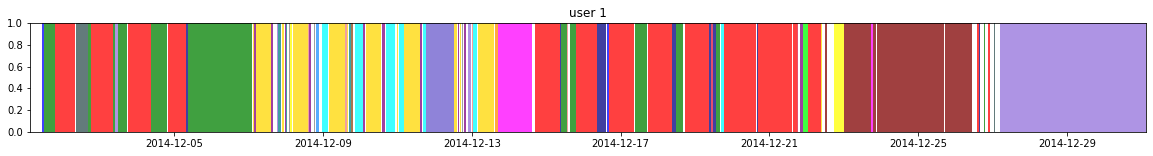

In [28]:
user = '1'
start_datetime = pd.to_datetime('2014-12-01 030000')
end_datetime = pd.to_datetime('2014-12-31 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

In [29]:
df_points = cstdf.groupby(['uid', 'cluster']).agg(
    {
         'lat':"mean",    # Sum duration per group
         'lng':"mean"
    }
)
locations = df_points[['lat', 'lng']]
locationlist = locations.values.tolist()

In [30]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[38.9, -77.05], zoom_start=6)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map2

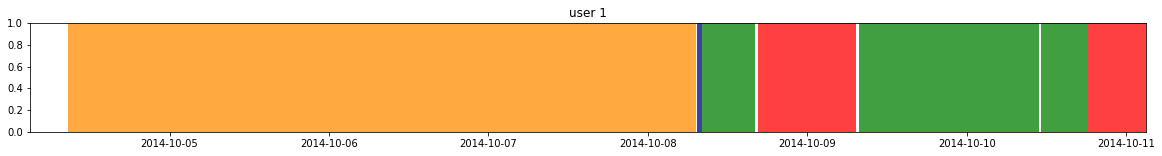

In [31]:
user = '1'
start_datetime = pd.to_datetime('2014-10-04 030000')
end_datetime = pd.to_datetime('2014-10-11 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

## Split trajectory into daily trajectories

In [32]:
import skmob
from skmob.utils import utils
from skmob.preprocessing import filtering, compression, detection, clustering

In [33]:
# Re-run all the preprocessing operations in one cell

tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=400.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

In [34]:
cstdf

uid                datetime        lat       lng        leaving_datetime  \
0      1 2014-10-04 08:40:42.085  43.409325  3.687527 2014-10-08 07:16:46.104   
1      1 2014-10-08 07:26:47.105  45.779960  4.875348 2014-10-08 08:04:42.104   
2      1 2014-10-08 08:04:42.104  45.787001  4.879866 2014-10-08 16:09:43.105   
3      1 2014-10-08 16:30:33.107  45.770915  4.869998 2014-10-09 07:16:39.993   
4      1 2014-10-09 07:45:18.984  45.787913  4.879948 2014-10-10 10:48:25.010   
...   ..                     ...        ...       ...                     ...   
7282  94 2014-12-10 11:40:17.914  45.764424  4.982879 2014-12-11 12:20:17.914   
7283  94 2014-12-11 12:20:17.914  45.764524  4.992879 2014-12-12 13:40:17.914   
7284  95 2014-12-10 11:50:17.914  45.764379  4.982879 2014-12-11 12:20:17.914   
7285  95 2014-12-11 12:20:17.914  45.764429  4.992879 2014-12-12 13:40:17.914   
7286  99 2015-06-25 19:15:43.599  45.760853  4.848437 2015-06-25 20:58:30.009   

      cluster  
0          15  
1           4  
2           1  
3           0  
4           1  
...       ...  
7282        1  
7283        0  
7284        1  
7285        0  
7286        0  

[7287 rows x 6 columns]

In [35]:
groups = utils.group_df_by_time(cstdf[cstdf['uid'] == '2'], 
                        offset_value=3, offset_unit='hours', add_starting_location=True)
groups[:3]

[  uid                datetime        lat       lng        leaving_datetime  \
 0   2 2014-10-18 13:53:22.017  45.779897  4.877692 2014-11-18 16:04:34.582   
 
    cluster  
 0        2  ,
   uid                datetime        lat       lng        leaving_datetime  \
 0   2 2014-10-18 13:53:22.017  45.779897  4.877692 2014-11-18 16:04:34.582   
 1   2 2014-11-18 16:04:34.582  45.787652  4.880308 2014-12-03 18:40:03.280   
 
    cluster  
 0        2  
 1        0  ,
   uid                datetime        lat       lng        leaving_datetime  \
 0   2 2014-11-18 16:04:34.582  45.787652  4.880308 2014-12-03 18:40:03.280   
 1   2 2014-12-03 18:57:53.529  45.771390  4.858208 2014-12-03 20:12:44.543   
 2   2 2014-12-03 20:28:23.519  45.780777  4.866307 2014-12-03 20:56:48.871   
 3   2 2014-12-03 20:56:48.871  45.769253  4.890268 2014-12-04 11:02:25.010   
 
    cluster  
 0        0  
 1        8  
 2        1  
 3       93  ]

In [36]:
from skmob.measures.individual import home_location

/home/abdelaziz/anaconda3/envs/skmob/lib/python3.7/site-packages/tqdm-4.41.1-py3.7.egg/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [37]:
hl_df = home_location(tdf)
print(hl_df[hl_df["uid"]=="18"])

100%|██████████| 85/85 [00:00<00:00, 117.53it/s]

   uid        lat       lng
13  18  45.755133  4.865007


In [38]:
def _work_location_individual(traj, start_day='08:00', end_day='18:00'):
    day_visits = traj.set_index(pd.DatetimeIndex(traj.datetime)).between_time(start_day, end_day)
    if len(day_visits) != 0:
        lat, lng = day_visits.groupby([constants.LATITUDE, constants.LONGITUDE]).count().sort_values(by=constants.DATETIME, ascending=False).iloc[0].name
    else:
        lat, lng = traj.groupby([constants.LATITUDE, constants.LONGITUDE]).count().sort_values(by=constants.DATETIME, ascending=False).iloc[0].name
    work_coords = (lat, lng)
    return work_coords

In [39]:
def work_location(traj, start_day='08:00', end_day='18:00', show_progress=True):
    # if 'uid' column in not present in the TrajDataFrame
    if constants.UID not in traj.columns:
        return pd.DataFrame([_work_location_individual(traj, start_day=start_day, end_day=end_day)], columns=[constants.LATITUDE, constants.LONGITUDE])
    
    if show_progress:
        df = traj.groupby(constants.UID).progress_apply(lambda x: _work_location_individual(x, start_day=start_day, end_day=end_day))
    else:
        df = traj.groupby(constants.UID).apply(lambda x: _work_location_individual(x, start_day=start_day, end_day=end_day))
    return df.apply(pd.Series).reset_index().rename(columns={0: constants.LATITUDE, 1: constants.LONGITUDE})

In [40]:
wl_df = work_location(tdf)
print(wl_df.head())

100%|██████████| 85/85 [00:00<00:00, 91.06it/s]

   uid        lat       lng
0    1  44.515405  4.780835
1  103  45.767555  4.833540
2  105  45.779282  4.874357
3  107  45.767632  4.833423
4  109  45.776110  4.890800


**Visualise the diaries of each sub-trajectory**

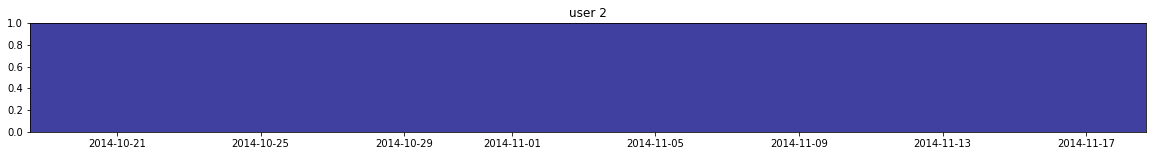

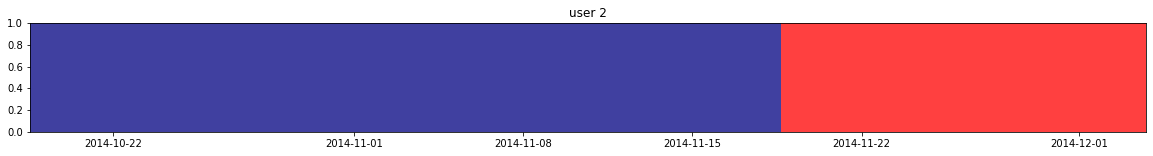

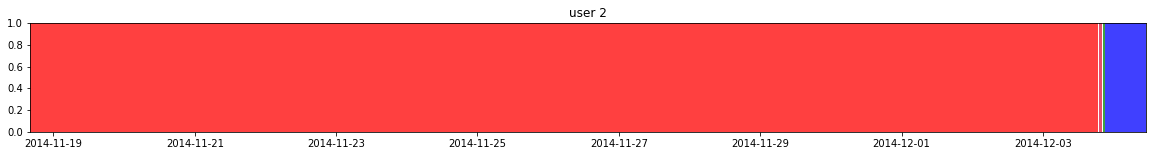

In [41]:
for tdf in groups[:3]:
    user = tdf['uid'].iloc[0]
    ax = tdf.plot_diary(user)

## Routing

Using OSMnx and networkx (taken from https://medium.com/@bobhaffner/osmnx-intro-and-routing-1fd744ba23d8).

In [42]:
import osmnx as ox
import folium

In [43]:
start_i = 0
dt_start = cstdf.iloc[start_i]['leaving_datetime']
dt_end = cstdf.iloc[start_i + 1]['datetime']
user_id = cstdf.iloc[start_i]['uid']

dt_start, dt_end

(Timestamp('2014-10-08 07:16:46.104000'),
 Timestamp('2014-10-08 07:26:47.105000'))

In [44]:
tdf1 = ftdf[(ftdf['datetime'] >= dt_start) & \
            (ftdf['datetime'] <= dt_end) & \
            (ftdf['uid'] == user_id)]
tdf1.plot_trajectory()

## Privacy Risk Assessment

* Simulate privacy attacks and assess risk with a worst-case scenario framework

* First, we import the necessary modules

In [45]:
from skmob.privacy import attacks
from skmob.core.trajectorydataframe import TrajDataFrame
from skmob.utils import constants

In [46]:
# Re-run all the preprocessing operations in one cell
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=300.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.5)
stdf = detection.stops(ctdf, stop_radius_factor=2, \
            minutes_for_a_stop=120.0, spatial_radius_km=1.0, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=1.0, min_samples=1)

In [47]:
cstdf

uid                datetime        lat       lng        leaving_datetime  \
0      1 2014-10-04 08:40:42.085  43.409325  3.687527 2014-10-08 07:16:46.104   
1      1 2014-10-08 08:04:42.104  45.787001  4.879866 2014-10-08 16:09:43.105   
2      1 2014-10-08 16:09:43.105  45.775603  4.874142 2014-10-09 07:45:18.984   
3      1 2014-10-09 07:45:18.984  45.785305  4.887950 2014-10-10 11:08:26.026   
4      1 2014-10-10 11:08:26.026  45.775788  4.898223 2014-10-10 18:15:32.240   
...   ..                     ...        ...       ...                     ...   
3034   9 2016-01-03 07:25:15.463  36.671006  2.737882 2016-01-03 15:06:03.450   
3035  93 2015-05-27 12:14:34.519  45.776263  4.870972 2015-05-27 15:26:33.355   
3036  93 2015-05-27 15:26:33.355  45.787070  4.879835 2015-06-15 17:16:36.940   
3037  93 2015-06-15 17:16:36.940  45.776455  4.871010 2015-06-16 10:11:53.480   
3038  93 2015-06-16 16:23:12.187  46.165927 -1.136800 2015-06-18 17:26:30.638   

      cluster  
0           4  
1           0  
2           0  
3           0  
4          52  
...       ...  
3034        1  
3035        0  
3036        2  
3037        0  
3038        1  

[3039 rows x 6 columns]

In [48]:
at = attacks.LocationAttack(knowledge_length=2)

In [49]:
at.assess_risk(cstdf)

uid  risk
0     1   1.0
1   105   1.0
2   107   1.0
3    11   1.0
4   110   1.0
..  ...   ...
70   85   1.0
71   87   1.0
72   89   1.0
73    9   1.0
74   93   1.0

[75 rows x 2 columns]

In [50]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="OT6-Attack")

N*(N+1)/2 relations

In [51]:
# df[df["cluster"]==14][["lat", "lng"]].loc[df["uid"].isin(['15', '17'])]

In [52]:
# test = df[df["cluster"]==2]#[["lat", "lng"]].loc[df["uid"]=="15"]
# test

In [53]:
# test = test.to_numpy()

In [54]:
# lat15, lng15 = test[0]

In [55]:
# coord = "{}, {}".format(lat15, lng15)
# coord

In [56]:
location = geolocator.reverse("45.7558, 4.8661")
location.raw

{'place_id': 101869946,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 62340578,
 'lat': '45.7552377',
 'lon': '4.866841492509142',
 'display_name': 'Mosquée Es-salem, Rue Baraban, La Villette, Lyon 3e Arrondissement, Lyon, Métropole de Lyon, Circonscription départementale du Rhône, Auvergne-Rhône-Alpes, France métropolitaine, 69001, France',
 'address': {'place_of_worship': 'Mosquée Es-salem',
  'road': 'Rue Baraban',
  'suburb': 'La Villette',
  'city_district': 'Lyon 3e Arrondissement',
  'city': 'Lyon',
  'county': 'Lyon',
  'state_district': 'Circonscription départementale du Rhône',
  'state': 'Auvergne-Rhône-Alpes',
  'country': 'France',
  'postcode': '69001',
  'country_code': 'fr'},
 'boundingbox': ['45.7551943', '45.7552975', '4.8667593', '4.8669285']}

In [57]:
# typePlace = list(location.raw["address"].keys())[0]
# typePlace

In [58]:
#relationShip = {"house_number": "family", "bus_stop": "friends, road buddies, colleagues"}colleagues

In [59]:
df = df[df["cluster"]!=-1]
clusters = set(df["cluster"])
clusters

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56}

In [60]:
df

uid                datetime        lat       lng  \
169    1 2015-01-07 18:28:26.996  45.771256  4.869458   
351    1 2015-03-10 12:56:50.334  45.778837  4.871297   
423   11 2014-12-11 18:39:56.273  45.011415 -0.644955   
455   13 2014-12-09 17:10:31.171  44.834488 -0.563362   
457   13 2014-12-10 07:40:59.013  44.850413 -0.570445   
...   ..                     ...        ...       ...   
5974   8 2014-12-11 17:13:49.960  44.848200 -0.571802   
6289  94 2014-12-10 11:40:17.914  45.764424  4.982879   
6290  94 2014-12-11 12:20:17.914  45.764524  4.992879   
6291  95 2014-12-10 11:50:17.914  45.764379  4.982879   
6292  95 2014-12-11 12:20:17.914  45.764429  4.992879   

                leaving_datetime  cluster  
169   2015-01-08 08:36:55.016000        1  
351   2015-03-10 14:17:33.332000        2  
423   2014-12-12 05:31:47.015000        3  
455   2014-12-09 22:11:00.467000        4  
457   2015-03-19 20:03:45.026000        5  
...                          ...      ...  
5974  2015-02-10 16:13:04.280000       24  
6289  2014-12-11 12:20:17.914000       55  
6290  2014-12-12 13:40:17.914000       56  
6291  2014-12-11 12:20:17.914000       55  
6292  2014-12-12 13:40:17.914000       56  

[116 rows x 6 columns]

In [61]:
meanData = []
for i in range(1, len(clusters)+1):
    latLngDate = df[df["cluster"]==i][["lat", "lng"]].to_numpy()#.loc[df["uid"].isin(['15', '17'])]
    toAdd = list(np.mean(latLngDate, axis=0))
    toAdd.append(df[df["cluster"]==i]["datetime"].iloc[0])
    toAdd.append(df[df["cluster"]==i]["leaving_datetime"].iloc[0])
    toAdd.insert(0, i)
    meanData.append(toAdd)
meanData = np.array(meanData)

In [62]:
dataset = pd.DataFrame({"uid": meanData[:, 0], 'lat': meanData[:, 1], 'lng': meanData[:, 2], 'datetime': meanData[:, 3], 'leaving_datetime': meanData[:, 4]})
dataset

uid      lat       lng                datetime        leaving_datetime
0    1  45.7711   4.86965 2015-01-07 18:28:26.996 2015-01-08 08:36:55.016
1    2  45.7789   4.87142 2015-03-10 12:56:50.334 2015-03-10 14:17:33.332
2    3  45.0114 -0.644802 2014-12-11 18:39:56.273 2014-12-12 05:31:47.015
3    4  44.8345 -0.563612 2014-12-09 17:10:31.171 2014-12-09 22:11:00.467
4    5  44.8504 -0.570367 2014-12-10 07:40:59.013 2015-03-19 20:03:45.026
5    6  44.8413 -0.572636 2014-12-08 19:46:25.894 2014-12-08 23:16:10.104
6    7   44.838 -0.577474 2014-12-10 17:27:21.766 2014-12-10 18:35:47.375
7    8  45.7871   4.88019 2014-12-05 14:45:05.976 2014-12-09 16:58:18.585
8    9  45.7871    4.8802 2014-12-05 12:50:59.509 2014-12-05 15:54:19.499
9   10   45.787    4.8797 2014-12-05 15:57:04.496 2014-12-09 16:58:08.953
10  11  44.8362 -0.567539 2014-12-09 22:20:03.740 2014-12-10 00:18:55.759
11  12  44.8379 -0.579897 2014-12-10 17:27:00.753 2014-12-10 18:30:59.743
12  13  45.2748   6.05679 2015-03-20 19:48:14.878 2015-03-21 08:43:25.022
13  14  45.7558   4.86558 2015-03-22 18:36:37.233 2015-03-23 15:08:30.806
14  15  45.7067   3.01905 2015-03-24 10:36:56.315 2015-03-24 13:21:20.305
15  16  45.7558   4.86608 2015-03-24 17:14:41.835 2015-04-08 23:30:28.750
16  17   48.872   2.77481 2015-04-13 18:44:27.733 2015-04-13 20:59:01.734
17  18  48.8734    2.7785 2015-04-14 06:48:56.953 2015-04-14 10:09:19.937
18  19  48.8713   2.77883 2015-04-14 10:56:03.976 2015-04-14 12:00:22.937
19  20  48.8738   2.77556 2015-04-14 12:00:22.937 2015-04-14 21:00:36.058
20  21  44.8497 -0.571595 2014-12-10 09:23:18.404 2014-12-10 17:18:49.670
21  22  44.8434 -0.575169 2014-12-10 18:35:37.645 2014-12-10 22:22:56.687
22  23   44.838 -0.578758 2014-12-10 17:27:20.374 2014-12-10 19:00:21.378
23  24  44.8482 -0.572085 2014-12-11 17:10:08.242 2014-12-11 17:48:42.226
24  25  45.7823   4.86598 2015-03-20 08:05:40.483 2015-03-25 11:14:57.865
25  26  45.7693    4.8661 2015-05-04 11:31:44.303 2015-05-04 20:08:22.946
26  27  45.7499   4.86445 2015-06-09 18:05:14.017 2015-06-09 19:17:59.500
27  28   45.751   4.86709 2015-12-01 07:17:23.270 2015-12-01 16:48:36.086
28  29  45.7788   4.87398 2015-03-06 06:58:17.601 2015-03-06 11:29:45.204
29  30  45.7701   4.87538 2015-03-05 17:30:39.273 2015-03-06 04:31:33.762
30  31  45.7787   4.87207 2015-11-02 11:10:42.726 2015-11-02 15:46:38.882
31  32  45.7786   4.87201 2015-11-03 11:21:58.997 2015-11-03 15:07:19.236
32  33  45.7787   4.87227 2015-11-13 11:06:06.846 2015-11-13 17:35:28.293
33  34  45.7787   4.87206 2015-11-18 11:06:01.013 2015-11-19 18:57:07.663
34  35  45.7787    4.8721 2015-12-03 11:10:02.999 2015-12-03 18:13:25.469
35  36  45.7786   4.87211 2015-12-04 11:08:54.575 2015-12-05 09:19:31.038
36  37  45.7787   4.87203 2015-12-14 11:15:22.828 2015-12-14 13:00:20.436
37  38   45.779   4.87226 2016-01-11 11:09:16.956 2016-01-11 23:53:09.513
38  39  45.7787   4.87227 2016-01-13 11:32:50.092 2016-01-13 14:57:20.016
39  40  45.7795   4.87281 2015-03-06 06:55:15.532 2015-03-07 23:32:58.132
40  41  45.7786   4.87212 2015-03-09 11:07:31.346 2015-03-09 15:53:30.542
41  42  45.7549   4.86625 2015-03-27 19:20:21.160 2015-03-28 14:29:00.805
42  43  45.2714   6.05538 2015-04-04 10:52:28.270 2015-04-04 12:02:38.115
43  44  48.8672   2.77829 2015-04-13 08:02:29.934 2015-04-13 15:19:46.407
44  45   48.874   2.79095 2015-04-13 21:07:46.923 2015-04-13 23:14:57.859
45  46  48.8708   2.77897 2015-04-14 16:29:23.279 2015-04-14 17:00:46.826
46  47  48.8716   2.77427 2015-04-15 17:28:45.135 2015-04-15 19:51:08.301
47  48  49.8732    2.3118 2015-04-15 22:51:05.848 2015-04-16 17:18:23.627
48  49  49.8678   2.27922 2015-04-19 11:06:07.456 2015-04-19 13:17:11.329
49  50  49.8732   2.31182 2015-04-19 13:22:11.404 2015-04-20 12:17:31.036
50  51  45.7558   4.86578 2015-04-23 18:43:04.414 2015-04-23 19:53:40.045
51  52  45.7559   4.86548 2015-04-24 16:54:01.369 2015-04-24 17:27:12.864
52  53   50.182   1.49693 2015-07-10 10:43:34.946 2015-07-10 13:58:23.619
53  54 

In [63]:
dd = skmob.TrajDataFrame(dataset, latitude=1, longitude=2, datetime=3)
dd

uid        lat       lng                datetime        leaving_datetime
0    1  45.771099  4.869648 2015-01-07 18:28:26.996 2015-01-08 08:36:55.016
1    2  45.778950  4.871416 2015-03-10 12:56:50.334 2015-03-10 14:17:33.332
2    3  45.011377 -0.644802 2014-12-11 18:39:56.273 2014-12-12 05:31:47.015
3    4  44.834463 -0.563612 2014-12-09 17:10:31.171 2014-12-09 22:11:00.467
4    5  44.850394 -0.570367 2014-12-10 07:40:59.013 2015-03-19 20:03:45.026
5    6  44.841264 -0.572636 2014-12-08 19:46:25.894 2014-12-08 23:16:10.104
6    7  44.838031 -0.577474 2014-12-10 17:27:21.766 2014-12-10 18:35:47.375
7    8  45.787144  4.880193 2014-12-05 14:45:05.976 2014-12-09 16:58:18.585
8    9  45.787101  4.880203 2014-12-05 12:50:59.509 2014-12-05 15:54:19.499
9   10  45.787041  4.879702 2014-12-05 15:57:04.496 2014-12-09 16:58:08.953
10  11  44.836237 -0.567539 2014-12-09 22:20:03.740 2014-12-10 00:18:55.759
11  12  44.837870 -0.579897 2014-12-10 17:27:00.753 2014-12-10 18:30:59.743
12  13  45.274778  6.056787 2015-03-20 19:48:14.878 2015-03-21 08:43:25.022
13  14  45.755838  4.865577 2015-03-22 18:36:37.233 2015-03-23 15:08:30.806
14  15  45.706743  3.019049 2015-03-24 10:36:56.315 2015-03-24 13:21:20.305
15  16  45.755790  4.866080 2015-03-24 17:14:41.835 2015-04-08 23:30:28.750
16  17  48.871969  2.774815 2015-04-13 18:44:27.733 2015-04-13 20:59:01.734
17  18  48.873390  2.778502 2015-04-14 06:48:56.953 2015-04-14 10:09:19.937
18  19  48.871342  2.778831 2015-04-14 10:56:03.976 2015-04-14 12:00:22.937
19  20  48.873795  2.775558 2015-04-14 12:00:22.937 2015-04-14 21:00:36.058
20  21  44.849749 -0.571595 2014-12-10 09:23:18.404 2014-12-10 17:18:49.670
21  22  44.843424 -0.575169 2014-12-10 18:35:37.645 2014-12-10 22:22:56.687
22  23  44.838032 -0.578758 2014-12-10 17:27:20.374 2014-12-10 19:00:21.378
23  24  44.848207 -0.572085 2014-12-11 17:10:08.242 2014-12-11 17:48:42.226
24  25  45.782281  4.865982 2015-03-20 08:05:40.483 2015-03-25 11:14:57.865
25  26  45.769308  4.866102 2015-05-04 11:31:44.303 2015-05-04 20:08:22.946
26  27  45.749930  4.864454 2015-06-09 18:05:14.017 2015-06-09 19:17:59.500
27  28  45.750957  4.867088 2015-12-01 07:17:23.270 2015-12-01 16:48:36.086
28  29  45.778795  4.873984 2015-03-06 06:58:17.601 2015-03-06 11:29:45.204
29  30  45.770143  4.875385 2015-03-05 17:30:39.273 2015-03-06 04:31:33.762
30  31  45.778666  4.872065 2015-11-02 11:10:42.726 2015-11-02 15:46:38.882
31  32  45.778646  4.872008 2015-11-03 11:21:58.997 2015-11-03 15:07:19.236
32  33  45.778673  4.872270 2015-11-13 11:06:06.846 2015-11-13 17:35:28.293
33  34  45.778667  4.872059 2015-11-18 11:06:01.013 2015-11-19 18:57:07.663
34  35  45.778709  4.872102 2015-12-03 11:10:02.999 2015-12-03 18:13:25.469
35  36  45.778649  4.872109 2015-12-04 11:08:54.575 2015-12-05 09:19:31.038
36  37  45.778699  4.872026 2015-12-14 11:15:22.828 2015-12-14 13:00:20.436
37  38  45.778957  4.872257 2016-01-11 11:09:16.956 2016-01-11 23:53:09.513
38  39  45.778674  4.872271 2016-01-13 11:32:50.092 2016-01-13 14:57:20.016
39  40  45.779481  4.872809 2015-03-06 06:55:15.532 2015-03-07 23:32:58.132
40  41  45.778627  4.872119 2015-03-09 11:07:31.346 2015-03-09 15:53:30.542
41  42  45.754890  4.866252 2015-03-27 19:20:21.160 2015-03-28 14:29:00.805
42  43  45.271432  6.055376 2015-04-04 10:52:28.270 2015-04-04 12:02:38.115
43  44  48.867187  2.778288 2015-04-13 08:02:29.934 2015-04-13 15:19:46.407
44  45  48.874047  2.790946 2015-04-13 21:07:46.923 2015-04-13 23:14:57.859
45  46  48.870847  2.778966 2015-04-14 16:29:23.279 2015-04-14 17:00:46.826
46  47  48.871595  2.774270 2015-04-15 17:28:45.135 2015-04-15 19:51:08.301
47  48  49.873203  2.311803 2015-04-15 22:51:05.848 2015-04-16 17:18:23.627
48  49  49.867779  2.279216 2015-04-19 11:06:07.456 2015-04-19 13:17:11.329
49  50  49.873225  2.311818 2015-04-19 13:22:11.404 2015-04-20 12:17:31.036
50  51  45.755792  4.865781 2015-04-23 18:43:04.414 2015-04-23 19:53:40.045
51  52  45.755879  4.865482 2015-04-24 16:54:01.369

In [66]:
map_f = dd.plot_trajectory(max_points=1, hex_color=-1, start_end_markers=False)
dd.plot_stops(map_f=map_f, hex_color=-1)
dd[10:20].plot_stops(map_f=map_f, hex_color=-1)
dd[20:30].plot_stops(map_f=map_f, hex_color=-1)
dd[30:40].plot_stops(map_f=map_f, hex_color=-1)
dd[40:50].plot_stops(map_f=map_f, hex_color=-1)
dd[50:56].plot_stops(map_f=map_f, hex_color=-1)

In [73]:
places = []
name = []
address = []
for i in range(50, len(clusters)):#len(clusters)):
    test = dataset[dataset["uid"]==i][["lat", "lng"]]
    test = test.to_numpy()
    lat, lng = test[0]
    coord = "{}, {}".format(lat, lng)
    location = geolocator.reverse(coord)
    places.append(list(location.raw["address"].keys())[0])
    name.append(list(location.raw["address"].values())[0])
    address.append(location.raw["display_name"])
places

['house_number',
 'house_number',
 'house_number',
 'road',
 'university',
 'stadium']

In [ ]:
name

In [ ]:
address

In [ ]:
test = dataset[dataset["uid"]==45][["lat", "lng"]]
test = test.to_numpy()
lat, lng = test[0]
coord = "{}, {}".format(lat, lng)
location = geolocator.reverse(coord)
location.raw

In [ ]:
location = geolocator.geocode("Maison du Tourisme de la Gironde")
location.raw

In [ ]:
coord

In [ ]:
hl_df

In [ ]:
datetimelist = list(dataset["datetime"])[:60]
leavingtimelist = list(dataset["leaving_datetime"])[:60]

In [ ]:
hl_df["datetime"] = datetimelist
hl_df["leaving_datetime"] = leavingtimelist

In [ ]:
hl_dd = skmob.TrajDataFrame(dataset, latitude=1, longitude=2, datetime=3)

In [ ]:
hl_dd[10:20]

In [ ]:
map_f = hl_dd.plot_trajectory(max_points=1, start_end_markers=False)
hl_dd.plot_stops(map_f=map_f)
hl_dd[10:20].plot_stops(map_f=map_f)
hl_dd[20:30].plot_stops(map_f=map_f)
hl_dd[30:40].plot_stops(map_f=map_f)
hl_dd[40:50].plot_stops(map_f=map_f)
hl_dd[50:60].plot_stops(map_f=map_f)

In [84]:
def get_unique_id(df):
    ids = df['uid']
    unique_id = set()
    for ident in ids:
        unique_id.add(ident)
    return unique_id
a = get_unique_id(df)
a

{'1',
 '11',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '23',
 '24',
 '30',
 '31',
 '35',
 '4',
 '40',
 '42',
 '43',
 '44',
 '50',
 '53',
 '57',
 '59',
 '63',
 '66',
 '67',
 '72',
 '77',
 '8',
 '94',
 '95'}

In [82]:
liste = np.zeros((33, 33))
liste

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for i in range(1, len(clusters)):
    for index, row in df.iterrows():

In [86]:
for index, row in df.iterrows():
    print(row)

uid                                          1
datetime            2015-01-07 18:28:26.996000
lat                                    45.7713
lng                                    4.86946
leaving_datetime    2015-01-08 08:36:55.016000
cluster                                      1
Name: 169, dtype: object
uid                                          1
datetime            2015-03-10 12:56:50.334000
lat                                    45.7788
lng                                     4.8713
leaving_datetime    2015-03-10 14:17:33.332000
cluster                                      2
Name: 351, dtype: object
uid                                         11
datetime            2014-12-11 18:39:56.273000
lat                                    45.0114
lng                                  -0.644955
leaving_datetime    2014-12-12 05:31:47.015000
cluster                                      3
Name: 423, dtype: object
uid                                         13
datetime            2014-12-09 1

In [ ]:
mapDT = {}
